# Analysis of responses to naturalistic images
------

#### Import packages

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache, BrainObservatoryNwbDataSet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import data, exposure
from scipy.stats import zscore
import pandas as pd 
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split

#### Visualize cells

In [7]:
filter_json = """
[
    {
        "field": "area",
        "op": "in",
        "value": [
            "VISp"
        ]
    },
    {
        "field": "tld1_name",
        "op": "in",
        "value": [
            "Slc17a7-IRES2-Cre"
        ]
    }
]
"""
       
filters = json.loads(filter_json)
boc = BrainObservatoryCache(manifest_file="brain_observatory/manifest.json")
cells = boc.get_cell_specimens(filters=filters)
cells_df = pd.DataFrame(cells)
cells_df.columns.unique().tolist()
cont_ids = cells_df['experiment_container_id'].unique()
experiments = boc.get_ophys_experiments(experiment_container_ids=cont_ids, include_failed=False, require_eye_tracking=True)
exp_ids = [d['id'] for d in experiments]
exp_ids = exp_ids[:20]

#### Retrieve experiment data

In [8]:
id = exp_ids[2]
boc.get_ophys_experiment_stimuli(id)


['static_gratings', 'natural_scenes', 'natural_movie_one', 'spontaneous']

In [9]:

exp2 = boc.get_ophys_experiment_data(id)
exp2.get_stimulus_epoch_table()

,stimulus,start,end
0,static_gratings,742,15189
1,natural_scenes,16093,30540
2,spontaneous,30690,39568
3,natural_scenes,39569,54016
4,static_gratings,54919,69366
5,natural_movie_one,70269,79298
6,natural_scenes,80201,96077
7,static_gratings,97357,113608


#### Load stimulus template

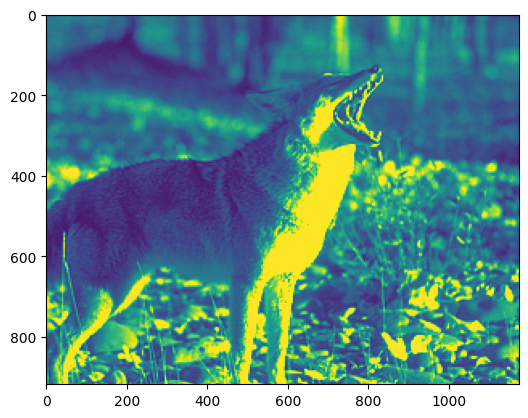

In [10]:
ims = exp2.get_stimulus_template('natural_scenes')
plt.imshow(ims[14,:,:])

#### Get stimulus analysis

In [6]:
a = boc.get_ophys_experiment_analysis(id, 'natural_scenes')

2022-10-24 16:08:18,992 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662951494


In [7]:
resp = a.get_response()

In [8]:
#get_response() docstring

#  ''' Computes the mean response for each cell to each stimulus
# condition.  Return is
# a (# scenes, # cells, 3) np.ndarray.  The final dimension
# contains the mean response to the condition (index 0), standard
# error of the mean of the response
# to the condition (index 1), and the number of trials with a
# significant (p < 0.05) response
# to that condition (index 2).'''

resp.shape


(119, 229, 3)

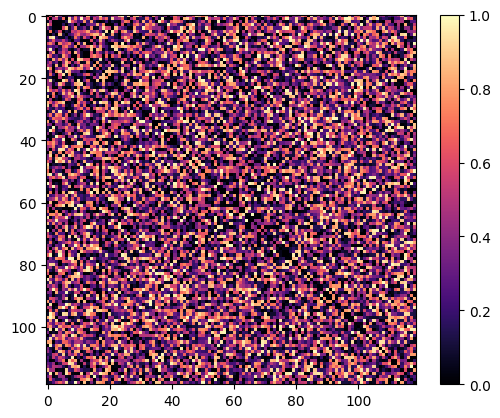

In [9]:
# plt.imshow(a.get_representational_similarity()[0,:,:])
repsim = a.get_representational_similarity()
plt.imshow(repsim[1], cmap = 'magma')
plt.colorbar()

#### Load stimulus data

In [10]:
stim_table = a.stim_table
stim_table['image_set'] = np.nan
stim_table.loc[stim_table['frame']<0, 'image_set'] = 0
stim_table.loc[(stim_table['frame']<=57)&(stim_table['frame']>=0), 'image_set'] = 1
stim_table.loc[(stim_table['frame']<=100)&(stim_table['frame']>=58), 'image_set'] = 2
stim_table.loc[(stim_table['frame']<=118)&(stim_table['frame']>=101), 'image_set'] = 3


## Dimensionality reduction

#### Average trials

c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

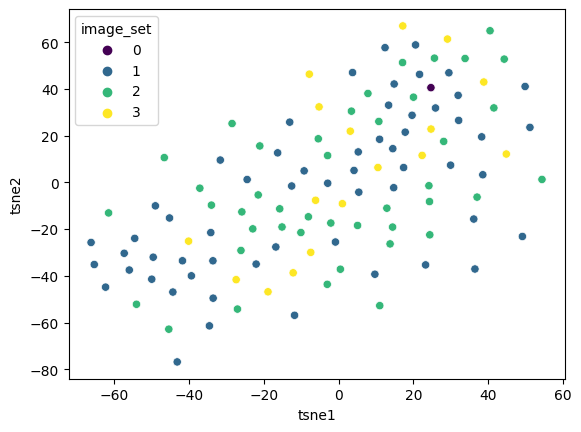

In [11]:
tsne = TSNE(n_components=2, random_state=42)

X = zscore(resp[:,:,0], axis = 0)
emb =tsne.fit_transform(X)
imset = np.array([0]+[1]*58 +[2]*(101-58)+[3]*(118-101)).T
emb_df = pd.DataFrame({'tsne1':emb[:,0],'tsne2':emb[:,1],'image_set':imset})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb_df, palette='viridis')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

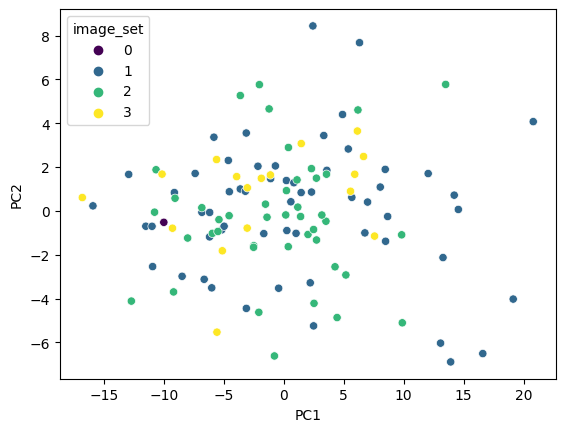

In [12]:
resp_tot = a.mean_sweep_response

pca = PCA(n_components=2)
# X = zscore(resp_tot.values, axis = 0)
emb = pca.fit_transform(X)

emb_df = pd.DataFrame({'PC1':emb[:,0], 'PC2':emb[:,1], 'image_set':imset})
sns.scatterplot(x = 'PC1', y = 'PC2', hue='image_set',data = emb_df, palette='viridis')

#### Single-trial responses

c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

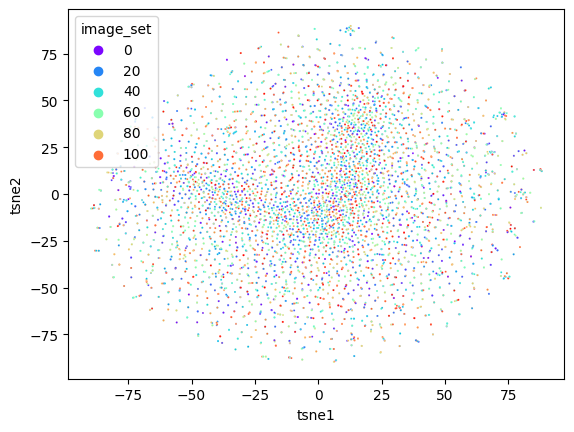

In [13]:
resp_tot = a.mean_sweep_response

tsne = TSNE(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = tsne.fit_transform(X)

emb2_df = pd.DataFrame({'tsne1':emb2[:,0], 'tsne2':emb2[:,1], 'image_set':stim_table['frame'].values})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb2_df, s = 2, palette='rainbow')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

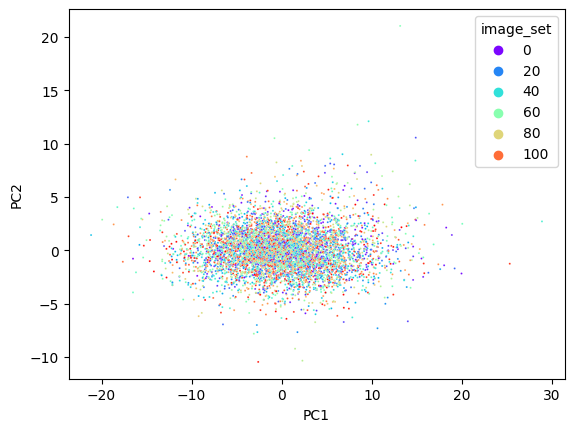

In [14]:
resp_tot = a.mean_sweep_response

pca = PCA(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = pca.fit_transform(X)

emb2_df = pd.DataFrame({'PC1':emb2[:,0], 'PC2':emb2[:,1], 'image_set':stim_table['frame'].values})
sns.scatterplot(x = 'PC1', y = 'PC2', hue='image_set',data = emb2_df, s = 2, palette='rainbow')

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

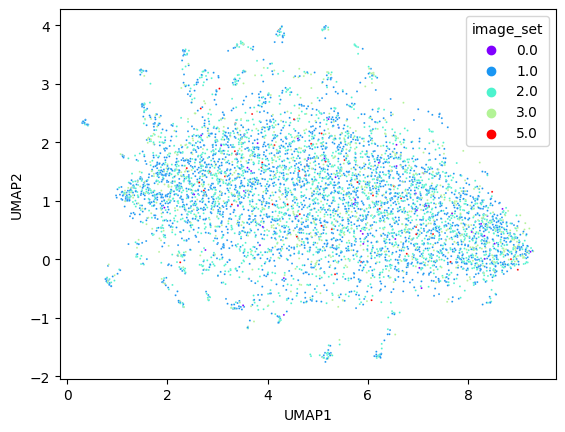

In [15]:
from umap import UMAP


umap = UMAP(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = umap.fit_transform(X)
stim_table.loc[stim_table['frame'] == 50, 'image_set'] = 5
emb2_df = pd.DataFrame({'UMAP1':emb2[:,0], 'UMAP2':emb2[:,1], 'image_set':stim_table['image_set']})
sns.scatterplot(x = 'UMAP1', y = 'UMAP2', hue='image_set',data = emb2_df, s = 2, palette='rainbow')

## Analysis of natural scene similarity

Text(34.08333333333333, 0.5, 'Image number')

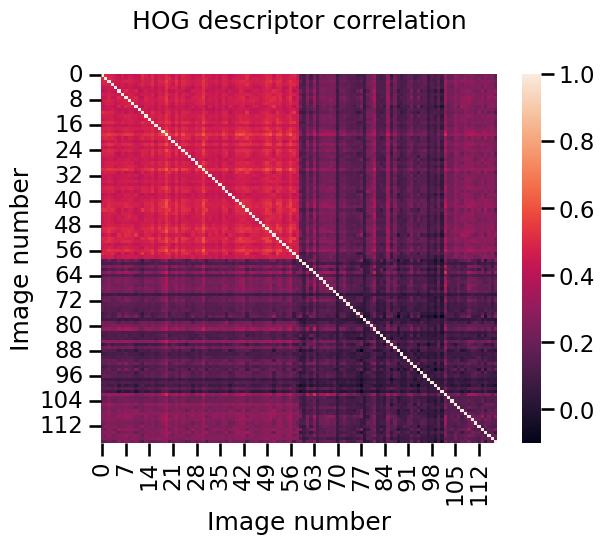

In [14]:
features =[]
sns.set_context('talk')
for i in range(ims.shape[0]):
    image = ims[i,:,:]

    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1,1), visualize=False)
    features.append(fd)
figures = pd.DataFrame(features)
r = np.corrcoef(figures.values)
dist = pairwise_distances(figures, metric='correlation')


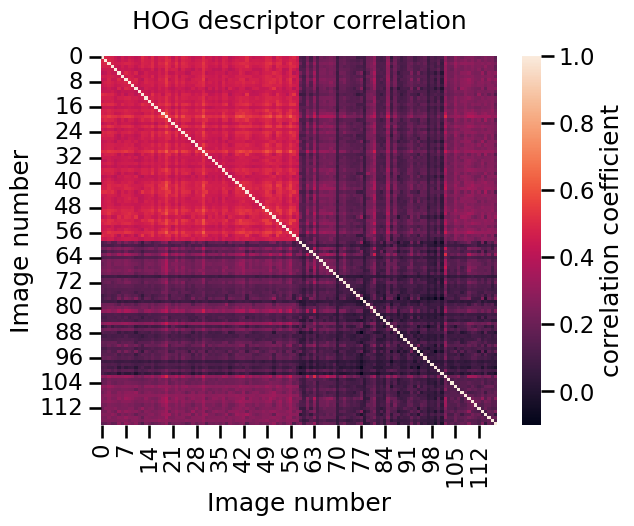

In [37]:

sns.heatmap(r, cbar_kws={'label': 'correlation coefficient'})

plt.title('HOG descriptor correlation', y= 1.05)
plt.xlabel('Image number')
# plt.tick_params(size = 18)
plt.ylabel('Image number')
# plt.colorbar(label = 'correlation coefficient')
plt.savefig('heatmap.svg', bbox_inches = 'tight')

In [17]:
cl = AgglomerativeClustering(n_clusters = 2, affinity='precomputed', linkage='single')
cl.fit(dist)

AgglomerativeClustering(affinity='precomputed', linkage='single')

In [18]:
# NOT WORKING 
# set distance_threshold to 0 and n_clusters to none


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# plot_dendrogram(cl)
# # plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# # plt.imshow(dist)
# plt.show()

In [19]:
labels = cl.fit_predict(dist)
image_map = {a:b for a, b in zip(np.arange(0,118), labels)}
image_map[-1] = 0
imclust = [image_map[im] for im in stim_table['frame'].values]

In [36]:
km = KMeans(n_clusters=2, random_state=42)

labels2 = km.fit_predict(figures.values)
image_map2 = {a:b for a, b in zip(np.arange(0,118), labels2)}
image_map2[-1] = 0
imclust2 = [image_map2[im] for im in stim_table['frame'].values]

c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

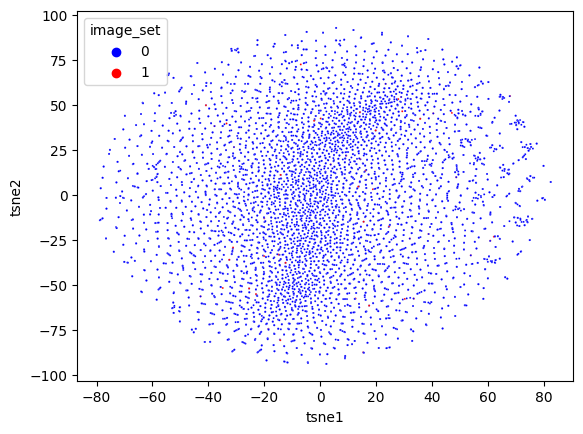

In [20]:
resp_tot = a.mean_sweep_response

tsne = TSNE(n_components=2)
X = zscore(resp_tot.values, axis = 0)
emb2 = tsne.fit_transform(X)

emb2_df = pd.DataFrame({'tsne1':emb2[:,0], 'tsne2':emb2[:,1], 'image_set':imclust})
sns.scatterplot(x = 'tsne1', y = 'tsne2', hue='image_set',data = emb2_df, s = 2, palette={1:'r',0:'b'})

## Stimulus decoding

Train a classifier to predict stimulus based on neural data

In [41]:
a.open_corona_plot(id)

ValueError: 656939127 is not in list

In [37]:
# train_dff, test_dff, train_im, test_im = train_test_split(resp_tot, stim_table['image_set'],random_state=42)

train_dff, test_dff, train_im, test_im = train_test_split(resp_tot,imclust2,random_state=42)

In [38]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=10, random_state=42)
rf.fit(train_dff, train_im)

RandomForestClassifier(n_estimators=400, n_jobs=10, random_state=42)

In [39]:
pred = rf.predict(test_dff)

accuracy_score(pred, test_im)

0.5268817204301075